## Problema del viajante

Resolver el problema del viajante utilizando algoritmos genéticos. 

- ¿Es posible aproximarse al resultado?

**Respuesta:** En este caso no fue posible aproximarse al resultado, ya que las cruzas, geneticas de valores muy aleatorios no tienen a acercarse a un valor óptimo sino mas bien a alejarse.

## Codificación

- Definir como se codificará el problema

**Respuesta:** La codificación consiste en una lista cuyos indices indican en el orden que se recorreran las ciudades *(genes)* y sus valores son inciales representando a cada ciudad *(gen)*

## Adaptación

- Definir como se calculará la adaptación de un individuo
- ¿Existen estados que deben ser penalizados?


**Respuesta:** La adaptación se obtiene calculando la distancia total del viaje, penalizando los casos donde el valor obtenido sea muy grande.

In [1]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import itertools
import json
import random


### Carga de datos Json

In [2]:
with open('distances.json', 'r') as file:
    distances = json.loads(file.read())

all_cities = list(distances.keys())
all_cities

['SR', 'EN', 'ES', 'JP', 'VA', 'LM', 'SDLR', 'RC', 'MC', 'GA', 'RA']

### Crear combinaciones

In [3]:
total_combinations = []
random_combinations = []
for combination in itertools.permutations(all_cities):
# Apendar primer ciudad al final de cada combinación para cumplir con el incio = final
    comb_list = list(combination)
    comb_list.append(combination[0])
    combination = tuple(comb_list)
    total_combinations.append(combination)

# Aumentar range para mas muestras en la población
for x in range(8):
    choice = random.choice(total_combinations)
    random_combinations.append(choice)
    total_combinations.remove(choice)
    
    
random_combinations

[('SR', 'ES', 'SDLR', 'VA', 'RC', 'RA', 'MC', 'EN', 'JP', 'LM', 'GA', 'SR'),
 ('RC', 'EN', 'MC', 'LM', 'VA', 'GA', 'SR', 'RA', 'JP', 'SDLR', 'ES', 'RC'),
 ('VA', 'SR', 'ES', 'EN', 'GA', 'RA', 'SDLR', 'LM', 'RC', 'JP', 'MC', 'VA'),
 ('RC', 'JP', 'SDLR', 'LM', 'RA', 'SR', 'EN', 'GA', 'ES', 'VA', 'MC', 'RC'),
 ('MC', 'EN', 'SR', 'LM', 'SDLR', 'RA', 'ES', 'VA', 'GA', 'JP', 'RC', 'MC'),
 ('RA', 'LM', 'SR', 'RC', 'SDLR', 'JP', 'EN', 'ES', 'MC', 'GA', 'VA', 'RA'),
 ('JP', 'RC', 'RA', 'VA', 'SDLR', 'GA', 'EN', 'ES', 'LM', 'SR', 'MC', 'JP'),
 ('MC', 'RA', 'EN', 'ES', 'RC', 'SR', 'SDLR', 'VA', 'GA', 'JP', 'LM', 'MC')]

### Calcular distancia por combinacion

In [4]:
def calculate_distance(combination: list) -> int:
    """Busco la distancia de la combinacion en el json"""
    distance = 0
    start = combination[0]
    combination_list = list(combination)
    combination_list.pop(0)
    combination = tuple(combination_list)
    
    for city in combination:
        distance += distances[start][city]
        start = city
        
    return distance

## Función de Adaptación

In [5]:
def adaptation_function(trips: list) -> list:
    fitness = []
    for trip in trips:
        distance = calculate_distance(trip)
        fitness.append(-distance)
    return fitness

## Selección

### Selección por ranking

In [6]:
def ranking_selection(adapted_population: list, random_combinations: list) -> list:
    """Esta funcion tiene que hacer el ranking"""
    parents = []
    zipped =  list(zip(random_combinations, adapted_population))
    zipped.sort(key=lambda z: z[1], reverse=True)
    for k in zipped:
        parents.append(k[0])
    return parents[:4]

## Cruza

In [7]:
def uniform_cross(parents: list) -> list:
    """La cruza uniforme selecciona bits(ciudades) aleatorios del padre 1 y padre 2 creando 2 hijos y no se tienen que repetir ciudades"""
    silbings = []
    parents_copy = parents
    # Selecciono los 2 primeros padres y tiene que ser mayor a 1 para que puedan ser padres pares
    while len(parents_copy) > 1:
        
        parent1 = random.choice(parents_copy)
        parents_copy.remove(parent1)
        parent2 = random.choice(parents_copy)
        parents_copy.remove(parent2)
    
        child1 = list()
        child2 = list()
        
        for city1, city2 in zip(parent1, parent2):
            # Probabilidad 0,5 de cambiar
            change = round(random.uniform(0, 1), 2)
            if change <= 0.5 and city1 not in child1 and city2 not in child2:
                child1.append(city1)
                child2.append(city2)
            else:
                if city2 not in child1:
                    child1.append(city2)
                      
                if city1 not in child2:
                    child2.append(city1)
                    
        for city in parent1:
            if city not in child1:
                child1.insert(len(child1) - 2, city)
            if city not in child2:
                child2.insert(len(child2) - 2, city)
                
        # Correción para que el último valor 
        if child1[0] != child1[len(child1) -1]:
            child1.append(child1[0])
        if child2[0] != child2[len(child2) -1]:
            child2.append(child2[0])
            
        silbings.append(child1)
        silbings.append(child2)
        
    return silbings
            

## Mutación

### Mutación por intercambio para conservar la no repetición de ciudades salvo primera y última

In [8]:
def mutate_children(children: list) -> list:
    mut_prob = 0.666
    for child in children:
    
        should_mutate = round(random.uniform(0, 1), 3) < mut_prob
    
        if not should_mutate:
            continue
    
        index = random.choice(list(range(1, 11)))
        index2 = random.choice(list(range(1, 11)))
    
        child[index], child[index2] = child[index2], child[index]
    

# Algoritmo

In [9]:
best_trips = []
generation = []
population = random_combinations
for i in range(400):
    adapted_population = adaptation_function(population)
    parents = ranking_selection(adapted_population, population)
    silbings = uniform_cross(parents)
    mutate_children(silbings)
    
    new_population = silbings
    new_population.extend(parents)
    best_trip = max(adaptation_function(new_population))
    best_trips.append(best_trip)
    generation.append(i)
    


### Gráfico

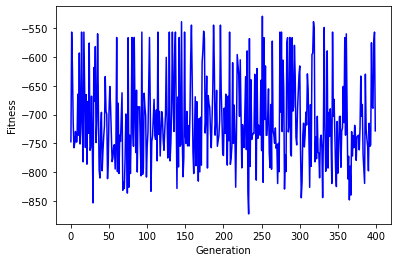

In [10]:
fig, ax = plt.subplots()
ax.plot(generation, best_trips, 'b')
ax.set_ylabel('Fitness')
ax.set_xlabel('Generation')
plt.show()